## Sampling large Datasets
In data processing, a great deal of computing involves analysing large amounts of text mixed with numerical data.  This is what Spark is particularly suited for. 
### Tasks to be finished
* Analyze the data find out the basic distribution characteristics
* Sampling with different combination of methods
* Sampling taking consideration with related data

## Amazon Movie dataset
INTERACTIONs DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file Amazon_xx.inter comprising the ratings of users over the items.
Each record/line in the file has the following fields: user_id, item_id, rating and timestamp.

user_id: the id of the users and its type is token. 
item_id: the id of the items and its type is token.
rating: the rating of the users over the item, and its type is float.
timestamp: the UNIX time of the interaction, and its type is float.

ITEMS INFORMATION DATASET FILE DESCRIPTION
------------------------------------------------------------------------------------
------------------------------------------------------------------------------------
The file Amazon_xx.item comprising the attributes of the items.
Each record/line in the file has the following fields: item_id, title, price, sales_type, sales_rank, brand, categories
 
item_id: the id of the item and its type is token.
title: the title of the item, and its type is token.
price: the price of the item, and its type is float.
sales_type: the type sales rank in, and its type is token. 
sales_rank: sales rank, and its type is float.
brand: the brand name of the item, and its type is token.
categories: the categories of the item, and its type is token_seq.

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Amazon Sampling").getOrCreate()

In [16]:
#Run the code in this box, and then continue running the boxes (in order) until the end of lesson.
# import pyspark
# conf = pyspark.SparkConf().setAppName("Amazon Sampling")

# try:
#     sc = pyspark.SparkContext(conf=conf)
# except:
#     print("Warning : a SparkContext already exists.")

# readin the top5 samples to get a glimpse of data
movietv5_inter_path = "./Amazon/5Lines/Amazon_Movies_and_TV.inter"
movietv5_item_path = "./Amazon/5Lines/Amazon_Movies_and_TV.item"



# read from file into dataframe
df_movietv5_inter= spark.read.option("delimiter",'\t').option("header", True).csv(movietv5_inter_path)
df_movietv5_inter.show()

df_movietv5_item= spark.read.option("delimiter",'\t').option("header", True).csv(movietv5_item_path)
df_movietv5_item.show()

# make timestamp more human-readible 
print(df_movietv5_inter["timestamp:float"])

from pyspark.sql.types import DateType
df_movietv5_inter.withColumn('timestamp:date', df_movietv5_inter["timestamp:float"].cast(DateType())).show()

+--------------+-------------+------------+---------------+
| user_id:token|item_id:token|rating:float|timestamp:float|
+--------------+-------------+------------+---------------+
|A3478QRKQDOPQ2|   0001527665|         5.0|     1362960000|
|A2VHSG6TZHU1OB|   0001527665|         5.0|     1361145600|
|A23EJWOW1TLENE|   0001527665|         5.0|     1358380800|
|A1KM9FNEJ8Q171|   0001527665|         5.0|     1357776000|
|A38LY2SSHVHRYB|   0001527665|         4.0|     1356480000|
+--------------+-------------+------------+---------------+

+-------------+--------------------+--------------------+-----------+----------------+----------------+
|item_id:token|         title:token|categories:token_seq|brand:token|sales_type:token|sales_rank:float|
+-------------+--------------------+--------------------+-----------+----------------+----------------+
|   0000695009|Understanding Sei...|            'Movies'|       null|     Movies & TV|        886503.0|
|   0000791156|Spirit Led&mdash;...|       

TypeError: 'DataFrame' object is not callable


## General Data Analysis
* uniqueness
* completness 
* lingage, concentration and sparsity

In [11]:
movietv_inter_path = "./Amazon/Amazon_Movies_and_TV/Amazon_Movies_and_TV.inter"
movietv_item_path = "./Amazon/Amazon_Movies_and_TV/Amazon_Movies_and_TV.item"
# read from file into dataframe
df_movietv_inter= spark.read.option("delimiter",'\t').option("header", True).csv(movietv_inter_path)

df_movietv_item= spark.read.option("delimiter",'\t').option("header", True).csv(movietv_item_path)

print("num of df_movietv_inter=",df_movietv_inter.count(),'\n')
print('num of df_movietv_item=',df_movietv_item.count())

def is_author_categories_defined(record):
    # print(record)
    return "title:token" and "categories:token_seq" in record

df_movietv_item_filt = df_movietv_item.rdd.filter(is_author_categories_defined)
print(df_movietv_item_filt.first())
print("num of filtered movietv iterm", df_movietv_item_filt.count())

num of df_movietv_inter= 8765568 

num of df_movietv_item= 181839
Row(item_id:token='0000695009', title:token='Understanding Seizures and Epilepsy', categories:token_seq="'Movies'", brand:token=None, sales_type:token='Movies & TV', sales_rank:float='886503.0')
num of filtered movietv iterm 181839


### Uniquenss
* no duplicated item_id
* no duplicated interaction from same user_id on same item_id

In [20]:
# extract item_ids
movietv_item_ids = df_movietv_item_filt.map(lambda item: item['item_id:token'])

print(movietv_item_ids.first())
# check if any dulicpated 
print("Duplicate item by ID:", movietv_item_ids.count() - movietv_item_ids.distinct().count())

AttributeError: 'PipelinedRDD' object has no attribute 'rdd'

In [19]:
# combine 
from pyspark.sql.functions import concat
df_movietv_inter = df_movietv_inter.withColumn("comb_key", concat(df_movietv_inter["user_id:token"],df_movietv_inter["item_id:token"]))

print(df_movietv_inter.first())

movietv_inter_comb_keys = df_movietv_inter.rdd.map(lambda inter: inter['comb_key'])

print("Duplicate interaction by combined(user, item):", movietv_inter_comb_keys.count() - movietv_inter_comb_keys.distinct().count())


Row(user_id:token='A3478QRKQDOPQ2', item_id:token='0001527665', rating:float='5.0', timestamp:float='1362960000', comb_key='A3478QRKQDOPQ20001527665')


AttributeError: 'DataFrame' object has no attribute 'map'

### Check the completeness 
* completeness attributes in item data 
* 

In [14]:
item_meta=movietv_item_ids.map(lambda item:item['item_id:token'])
# print("type of item_meta is",type(item_meta.first()),'\n')
print("first element of adelaide_meta is \n",item_meta.first())

print("keys of item_meta",item_meta.first().keys(),'\n')

item_keys = item_meta.flatMap(lambda rec: rec.keys())

#frequency of each key.
adelaide_key_value = item_keys.map(lambda key: (key, 1))
adelaide_key_value.first()

from operator import add

adelaide_agg = adelaide_key_value.reduceByKey(add)
adelaide_agg.collectAsMap()

24/04/05 17:33:09 ERROR Executor: Exception in task 0.0 in stage 56.0 (TID 120)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/rdd.py", line 2830, in takeUpToNumLeft
    yield next(iterator)
          ^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 56.0 failed 1 times, most recent failure: Lost task 0.0 in stage 56.0 (TID 120) (10.0.0.13 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/rdd.py", line 2830, in takeUpToNumLeft
    yield next(iterator)
          ^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_91395/1940389966.py", line 1, in <lambda>
TypeError: string indices must be integers, not 'str'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:179)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:179)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/rdd.py", line 2830, in takeUpToNumLeft
    yield next(iterator)
          ^^^^^^^^^^^^^^
  File "/Users/qing/miniconda3/envs/CP631/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_91395/1940389966.py", line 1, in <lambda>
TypeError: string indices must be integers, not 'str'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:179)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2303)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


We can now compare the lengths of the original and new RDDs to see how many bad values have been filtered out.  Note that Spark uses lazy evaluation, so the actual computation and creation of new dataset is not actually carried out until its values are used.  So the line above might have evaluated in a fraction of a second, because no actual work has been done.  The RDD would actually be constructed in cell below, where its elements are actually accessed.  We can see that the new set has fewer elements than the original set, so some bad entries have indeed been present and are now filtered out.  First we also print the first elements of the original and new RDD just to see that they look reasonable.  This is a good habit to get into any time you generate a new dataset from an existing one.

## Caching

When we expect to operate frequently on the same dataset, it might be useful to tell Spark to keep it in memory.  For that, we can use the cache() method.  If you plan to do a large operation on an RDD, apply the cache() method to it first.

## Data Characteristic Analysis
* skewness of items
  * attribute year
  * category
* sparsity of interactions
  * too few interaction on 
  * 

In [50]:
import re
def process_name_birth_death(record):
    author = record.get('author', None)
    if author:
        author = author.strip()
        # Remove trailing dot
        if '.' == author[-1]:
            author = author[:-1]
        try:
            lastname, firstname, birth_death = author.split(',')
        except ValueError:
            return record
        try:
            birth, death = re.findall('\d+', birth_death)
        except ValueError:
            return record
        record['author_lastname'] = lastname.strip()
        record['author_firstname'] = firstname.strip()
        record['author_birth'] = int(birth)
        record['author_death'] = int(death)
    return record

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3494965734.py:14: SyntaxWarning: invalid escape sequence '\d'
  birth, death = re.findall('\d+', birth_death)


We first run this function on a single dictionary to make sure it works correctly.

In [51]:
test=adelaide_meta.first()
process_name_birth_death(test)

{'publisher': 'The University of Adelaide Library',
 '@type': 'Book',
 '@context': 'http://schema.org',
 'url': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/',
 'dateCreated': '1851',
 'datePublished': '2010-03-27',
 'author': 'Le Fanu, Joseph Sheridan, 1814-1873.',
 'name': 'An Account of Some Strange Disturbances in Aungier Street',
 'dateModified': '2014-02-25',
 'keywords': 'Literature',
 'image': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/cover.jpg',
 'description': 'An Account of Some Strange Disturbances in Aungier Street / J. Sheridan Le Fanu',
 'inLanguage': 'en',
 'author_lastname': 'Le Fanu',
 'author_firstname': 'Joseph Sheridan',
 'author_birth': 1814,
 'author_death': 1873}

Once it is verified to work, we apply it to the whole RDD through a map.

In [52]:
adelaide_meta_val = adelaide_meta.map(process_name_birth_death)


We verify we did this correctly by looking the the first two elements of the resulting RDD.

In [53]:
adelaide_meta_val.take(2)

[{'publisher': 'The University of Adelaide Library',
  '@type': 'Book',
  '@context': 'http://schema.org',
  'url': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/',
  'dateCreated': '1851',
  'datePublished': '2010-03-27',
  'author': 'Le Fanu, Joseph Sheridan, 1814-1873.',
  'name': 'An Account of Some Strange Disturbances in Aungier Street',
  'dateModified': '2014-02-25',
  'keywords': 'Literature',
  'image': 'https://ebooks.adelaide.edu.au/l/lefanu/aungier/cover.jpg',
  'description': 'An Account of Some Strange Disturbances in Aungier Street / J. Sheridan Le Fanu',
  'inLanguage': 'en',
  'author_lastname': 'Le Fanu',
  'author_firstname': 'Joseph Sheridan',
  'author_birth': 1814,
  'author_death': 1873},
 {'publisher': 'The University of Adelaide Library',
  'image': 'https://ebooks.adelaide.edu.au/b/benson/ef/and-the-dead-spake/cover.jpg',
  'url': 'https://ebooks.adelaide.edu.au/b/benson/ef/and-the-dead-spake/',
  'name': 'And the Dead Spake',
  'description': 'And the Dea

We could also apply a transformation to change works created before year 0 CE to have a negative value, which might help in our analysis.  The function to do this is below:

In [54]:
def convert_dateCreated(record):
    if 'dateCreated' in record:
        dates = re.findall('\d+', record['dateCreated'])
        if len(dates) > 0:
            date = int(dates[0])
            # Check if the date is before common era
            if re.match(r'BC|bc|BCE|bce', record['dateCreated']):
                date *= -1
            record['dateCreated'] = date
        else:
            del record['dateCreated']
    return record

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3654922853.py:3: SyntaxWarning: invalid escape sequence '\d'
  dates = re.findall('\d+', record['dateCreated'])


We apply the function through a map.  In this case the new RDD overwrites the old RDD.

In [55]:
adelaide_meta_val = adelaide_meta_val.map(convert_dateCreated)


## First analysis: authors' life expectancy

Now that we have the metadata RDD filtered to our satisfaction, we can do some analysis on the data it contains.  To do this, we write a function that computes the age (at death) of the author.  It is not a perfect function in that it will get confused if an author's lifetime spanned year 0, but it's good enough for our purposes.  After the function is defined and applied through map() to the RDD, we then apply the count by countByValue method, which will count how many times each value is present and produce a list holding this information.  The resulting list is not an RDD, so we can work with it like with other standard Python objects.

In [56]:
def compute_age(rec):
    """Compute the age of an author when it died
    based on its year of birth and death.
    """
    if 'author_birth' and 'author_death' in rec:
        birth, death =  rec['author_birth'], rec['author_death']
        if birth < death:
            return death - birth
        else:
            # If year of birth is greater than year of death the
            # author was born in BCE. This will not be correct for authors 
            # who were alive 1 CE, crossing over the BCE and CE boundary,
            # but we will not worry about this artifact in this exercise.
            return birth - death
    else:
        return None

age_frequency = adelaide_meta_val.map(compute_age).countByValue()

print(age_frequency)

defaultdict(<class 'int'>, {59: 91, 73: 222, 78: 77, 83: 35, 58: 97, 48: 21, 49: 11, 47: 106, 84: 26, 76: 22, 74: 70, None: 478, 51: 86, 43: 318, 67: 130, 88: 38, 57: 25, 62: 85, 65: 170, 61: 59, 90: 10, 69: 48, 46: 97, 44: 96, 56: 54, 77: 88, 45: 58, 80: 146, 50: 11, 82: 111, 81: 75, 70: 58, 41: 13, 60: 48, 85: 15, 33: 7, 55: 84, 68: 97, 52: 97, 72: 48, 40: 61, 75: 85, 66: 108, 71: 86, 39: 12, 32: 2, 64: 39, 38: 50, 93: 8, 94: 11, 29: 11, 87: 5, 54: 20, 89: 22, 37: 12, 79: 37, 92: 2, 86: 7, 30: 9, 36: 7, 26: 13, 27: 1, 42: 9, 63: 16, 34: 10, 53: 3, 101: 1, 35: 7, 91: 1, 31: 1})


To understand this data we use the standard Python plotting library matplotlib.  Again, as with BeautifulSoup, mastering this library is outside the scope of this course.  Here we are using it as an utility.  If you want to understand it in more detail, refer to the tutorials available online.

[59, 73, 78, 83, 58, 48, 49, 47, 84, 76, 74, None, 51, 43, 67, 88, 57, 62, 65, 61, 90, 69, 46, 44, 56, 77, 45, 80, 50, 82, 81, 70, 41, 60, 85, 33, 55, 68, 52, 72, 40, 75, 66, 71, 39, 32, 64, 38, 93, 94, 29, 87, 54, 89, 37, 79, 92, 86, 30, 36, 26, 27, 42, 63, 34, 53, 101, 35, 91, 31]
[91, 222, 77, 35, 97, 21, 11, 106, 26, 22, 70, 478, 86, 318, 130, 38, 25, 85, 170, 59, 10, 48, 97, 96, 54, 88, 58, 146, 11, 111, 75, 58, 13, 48, 15, 7, 84, 97, 97, 48, 61, 85, 108, 86, 12, 2, 39, 50, 8, 11, 11, 5, 20, 22, 12, 37, 2, 7, 9, 7, 13, 1, 9, 16, 10, 3, 1, 7, 1, 1]
[73 78 83 58 48 49 47 84 76 74 None 51 43 67 88 57 62 65 61 90 69 46 44 56
 77 45 80 50 82 81 70 41 60 85 33 55 68 52 72 40 75 66 71 39 32 64 38 93
 94 29 87 54 89 37 79 92 86 30 36 26 27 42 63 34 53 101 35 91 31]
[222  77  35  97  21  11 106  26  22  70 478  86 318 130  38  25  85 170
  59  10  48  97  96  54  88  58 146  11 111  75  58  13  48  15   7  84
  97  97  48  61  85 108  86  12   2  39  50   8  11  11   5  20  22  12
  37   2

/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/3192641303.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,y,'.b-',linestyle='None')


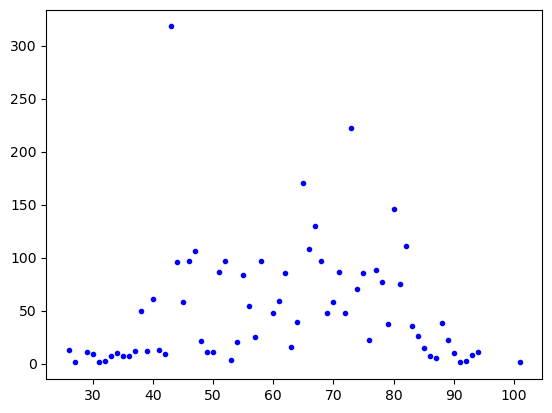

In [58]:
# need to add plot
import matplotlib
import matplotlib.pyplot as plt
import numpy

age=list(age_frequency.keys())
frequency=list(age_frequency.values())
print(age)
print(frequency)
x=numpy.array(age[1:]) # not taking the "None" key by starting at position 1
y=numpy.array(frequency[1:]) # not taking the "None" frequency by starting at position 1
print(x)
print(y)
#fig,ax=plt.subplots()
#ax.plot(x,y)
#plt.scatter(x,y)
plt.plot(x,y,'.b-',linestyle='None')
plt.show()
#run this box again if figure does not appear

(graphic generated by me in this notebook)

Our data has a strange spike at 43. Could we be doing something wrong?  Yes, we are considering multiple books by the same author separately.   Therefore, if there is one particular author that happens to be the author of a large number of books in this database, our results will be skewed.  To fix this, lets make a new RDD that consists of tuples with three elements each for an author: first name, last name, age.

In [59]:
def retrieve_name_age(rec):
    age = compute_age(rec)
    lastname = rec['author_lastname']
    firstname = rec['author_firstname']
    return firstname, lastname, age

authors = adelaide_meta_val.filter(lambda rec: 'author_lastname' in rec).map(retrieve_name_age)
authors.take(5)

[('Joseph Sheridan', 'Le Fanu', 59),
 ('E. F. (Edward Frederic)', 'Benson', 73),
 ('Jonathan', 'Swift', 78),
 ('Augustine', 'Birrell', 83),
 ('Nellie', 'Bly', 58)]

We can now apply the distinct() method to this RDD to eliminate indentical elements.  In the resulting dataset, each author is listed only once.

In [60]:
unique_authors = authors.distinct()
print(authors.count(),unique_authors.count())

3606 583


We can see that there are only 583 unique authors for our 3606 books.  We make the RDD containing only the age, and apply countByValue() method to get data for a new histogram.

In [61]:
age_frequency2 = unique_authors.map(lambda tup: tup[2]).countByValue()

We then plot it again with matplotlib.

[84, 74, 45, 80, 66, 29, 92, 30, 55, 83, 59, 78, 62, 46, 82, 54, 63, 58, 72, 75, 79, 68, 88, 71, 85, 73, 57, 51, 38, 47, 31, 61, 77, 56, 41, 34, 69, 50, 33, 26, 90, 35, 53, 81, 39, 37, 42, 101, 70, 65, 67, 64, 52, 43, 76, 48, 91, 27, 60, 32, 87, 44, 93, 36, 49, 89, 86, 40, 94]
[4, 12, 6, 21, 17, 4, 2, 3, 9, 13, 16, 12, 12, 13, 15, 9, 14, 16, 15, 21, 10, 19, 8, 15, 11, 13, 17, 9, 6, 11, 1, 15, 11, 10, 4, 4, 17, 6, 5, 3, 5, 4, 3, 10, 6, 6, 3, 1, 13, 18, 10, 10, 6, 5, 6, 10, 1, 1, 5, 1, 4, 6, 1, 1, 4, 5, 3, 5, 1]
[ 74  45  80  66  29  92  30  55  83  59  78  62  46  82  54  63  58  72
  75  79  68  88  71  85  73  57  51  38  47  31  61  77  56  41  34  69
  50  33  26  90  35  53  81  39  37  42 101  70  65  67  64  52  43  76
  48  91  27  60  32  87  44  93  36  49  89  86  40  94]
[12  6 21 17  4  2  3  9 13 16 12 12 13 15  9 14 16 15 21 10 19  8 15 11
 13 17  9  6 11  1 15 11 10  4  4 17  6  5  3  5  4  3 10  6  6  3  1 13
 18 10 10  6  5  6 10  1  1  5  1  4  6  1  1  4  5  3  5  1]

/var/folders/bj/spr6xdy950jf8sj2svjhs0vh0000gn/T/ipykernel_8561/233018324.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x,y,'.b-',linestyle='None')


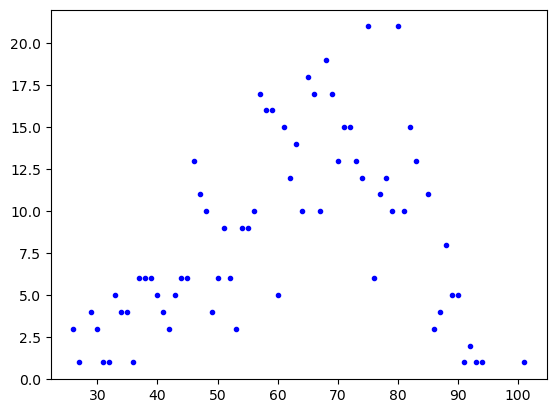

In [62]:
# need to add plot
import matplotlib
import matplotlib.pyplot as plt
import numpy

age=list(age_frequency2.keys())
frequency=list(age_frequency2.values())
print(age)
print(frequency)
x=numpy.array(age[1:]) # not taking the "None" key by starting at position 1
y=numpy.array(frequency[1:]) # not taking the "None" frequency by starting at position 1
print(x)
print(y)
#fig,ax=plt.subplots()
#ax.plot(x,y)
#plt.scatter(x,y)
plt.plot(x,y,'.b-',linestyle='None')
plt.show()

(figure generated by me)
Notice that the peak has disappeared.  Probably there were some authors aged 43 who happened to have a large number of books in our collection.  Not counting those books multiple times elimited the artifact. Now the data looks more regular and follows a clear trend.

## Working with full text

We now read in the .json files with full text that we have created by scraping the web previously.

In [63]:
# letter_range was defined above when reading meta files
adelaide_page_json = sc.textFile("./data/*page*"+letter_range+"*.json")
print(adelaide_page_json.count())


4458


There are 4458 elements in this RDD.

In [66]:
type(adelaide_page_json.first()) # at this point RDD consists of strings

str

At this point the RDD consists of strings.  Let's examine the first string. It happens to be a string with a link followed by "None", indicating that in this particular case the data for the book was not successfully retrieved during the web scraping operation.   Other entries will contain the link followed by the full HTML page code for that particular book.  We want to filter out the "None" entries but for that we will have to convert the data from a simple string into something more useful.

In [65]:
print(adelaide_page_json.first())

["https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/", "<!DOCTYPE html>\n\n<html xmlns=\"http://www.w3.org/1999/xhtml\">\n<head>\n<meta charset=\"utf-8\"/>\n<title>The Accursed Bread / Guy de Maupassant</title><script type=\"application/ld+json\">\n{\n   \"@context\" : \"http://schema.org\",\n   \"@type\" : \"Book\",\n   \"author\" : \"Maupassant, Guy de, 1850-1893\",\n   \"image\" : \"https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/cover.jpg\",\n   \"dateCreated\" : \"1883\",\n   \"datePublished\" : \"2016-01-26\",\n   \"description\" : \"The Accursed Bread : (Le Pain Maudit) / Guy de Maupassant\",\n   \"inLanguage\" : \"en\",\n   \"name\" : \"The Accursed Bread\",\n   \"publisher\" : \"The University of Adelaide Library\",\n   \"keywords\" : \"Literature\",\n   \"url\" : \"https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/\"\n}\n</script>\n<!-- open graph -->\n<meta content=\"The Accursed Bread\" property=\"og:title\"/>\n<meta content=\"The Ac

We must now convert these strings into Python objects that we can manipulate further. We can use the json module for this.

The entry consists of a list with two elements: the url of a page followed by the HTML content of the page.  We should get rid of entries containing "None".

In [67]:
adelaide_page = adelaide_page_json.map(json.loads)

We examine the type of data in this new RDD and see that it consists of lists, each with two items in it.

In [68]:
#print(adelaide_page.first())
print(type(adelaide_page.first()))
# now RDD of lists, each containing two strings
print(len(adelaide_page.first()))

<class 'list'>
2


Now we filter out the "None" entries i.e. those which have "None" at index 1 in the list.

In [ ]:
adelaide_page = adelaide_page.filter(lambda rec: rec[1] != "None")
print(adelaide_page.count())

The count call shows how many elements remain. After the filtering, we can look at the first of the remaining valid elements, showing the html code.

In [69]:
book=adelaide_page.first()
print(book[0])
print("--------------")
print(type(book[1])) # string containing HTML code for book
print("--------------")
print(book[1][0:500]) # print only first 500 characters for brevity

https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/
--------------
<class 'str'>
--------------
<!DOCTYPE html>

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta charset="utf-8"/>
<title>The Accursed Bread / Guy de Maupassant</title><script type="application/ld+json">
{
   "@context" : "http://schema.org",
   "@type" : "Book",
   "author" : "Maupassant, Guy de, 1850-1893",
   "image" : "https://ebooks.adelaide.edu.au/m/maupassant/guy/accursed-bread/cover.jpg",
   "dateCreated" : "1883",
   "datePublished" : "2016-01-26",
   "description" : "The Accursed Bread : (Le Pain Maudit) / G


It turns out that some books are present multiple times in our dataset.  But we want to have each book present only once.

If the RDD consists of key,value pairs, for example:

(a,1) (a,2) (b,1) (c,1) (c,2)

then the groupByKey method of the RDD will return a new RDD consisting of

(a, [1,2]) (b,[1,]) (c,[1,2])

i.e. it will consist of keys followed by a list of values in the original RDD associated with that key.

In our case we apply the groupByKey operation, then convert the values of the resulting RDD into a list (using the Python list function), and then keep only one element of that list, using the itemgetter[0] Python function which, when applied to a list, returns its first element (with index 0).

In this way, if the book with a specific URL key was present multiple times in our RDD, we keep the value with one occurence of the key.


In [70]:
from operator import itemgetter
adelaide_page_unique = adelaide_page.groupByKey()\
                                    .mapValues(list)\
                                    .mapValues(itemgetter(0))
print(adelaide_page_unique.count())

4150


We can see that indeed there were books showing up multiple times in our RDD, since after this operation the number of elements in our RDD is further reduced.

At this point the values in our RDD store a sting of raw HTML code of the page for the book. We then want to filter out everything except the actual text of the book which we will want to analyze further.  We do that by working with Beautiful Soup and eliminating unnecessary tags.

In [71]:
book=adelaide_page_unique.first()
print(type(book))
print(book[0])
print(book[1][0:500])

<class 'tuple'>
https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/
<!DOCTYPE html>

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta charset="utf-8"/>
<title>The Adventures of Harry Richmond / George Meredith</title><script type="application/ld+json">
{
   "@context" : "http://schema.org",
   "@type" : "Book",
   "author" : "Meredith, George, 1828-1909",
   "image" : "https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/cover.jpg",
   "dateCreated" : "1871",
   "datePublished" : "2016-01-11",
   "description" : "The Adventures o


We want to clean up the text by removing a series of tags.  We can use the extract method of BeautifulSoup object. We also use the chain method to define a series of findAll operations in an iterable which we can then loop over.

In [73]:
from itertools import chain
from operator import itemgetter
from bs4 import BeautifulSoup

def extract_text(page):
    if page:
        soup = BeautifulSoup(page, 'html.parser')
        it = chain(soup.findAll(['meta', 'script', 'head']),
                   soup.findAll('div', {"id" : "controls"}),
                   soup.findAll('div', {"class" : "contents"}),
                   soup.findAll('div', {"class" : "titleverso"}),
                   soup.findAll('div', {"class" : "colophon"}),
                   soup.findAll('span', {"class" : "author"}))
        for div in it:
            div.extract()
        return soup.get_text().strip()

In [74]:
adelaide_text = adelaide_page_unique.mapValues(extract_text)

Now we have an RDD which contains the pure text of the book without any HTML.

In [75]:
book_text=adelaide_text.first()
print(type(book_text))
print(book_text[0])
print(book_text[1][0:600])

<class 'tuple'>
https://ebooks.adelaide.edu.au/m/meredith/george/adventures-of-harry-richmond/
The Adventures
of
Harry Richmond










Table of Contents


I am a Subject of Contention

An Adventure on my own Account

Dipwell Farm

I have a Taste of Grandeur

I make a Dear Friend

A Tale of a Goose

A Free Life on the Road

Janet Ilchester

An Evening with Captain Bulsted

An Expedition

The great Fog and the Fire at Midnight

We find ourselves Bound on a Voyage

We Conduct several Learned Arguments with the Captain of the Priscilla

I Meet old Friends

We are Accosted by a Beautiful little Lady in the Forest

The Statue on the Promontory

My Father Breathes, Moves, and Speaks

We Pas


We now have a large dataset that will be a bit unwieldy to work with if we want our operations to be completed in a reasonable amount of time.

To make thinks a bit easier, we will restrict our analysis to books written in the modern era, in this case defined as between 1900 and 1938. We can easily identify these books using our meta RDD we created previously, and applying a filter on the value of dateCreated.

In [76]:
modern_era_books = adelaide_meta_val.filter(lambda rec: 1900 < rec.get('dateCreated', 0) < 1938)

We also want to filter out all books not in English. Again we use the metadata RDD, which we filter further.

In [77]:
modern_era_en_books = modern_era_books.filter(lambda rec: rec.get('inLanguage', '') == 'en')

In [78]:
modern_era_en_books.count()

398

The meta information about each book and the book's text are stored in two separate RDDs..

In [79]:
modern_era_books.map(lambda rec: rec['author']).distinct().count()

130

The meta information about each book and the book's text are each stored in two separate RDDs. In order to retrieve the texts written during the modernism era, we will need to join the RDD of modern book era meta information and the RDD of books' text.  The join operation takes two key-value RDDs and produces a new RDD consisting of those values in the original RDDs which share identical keys.  

First we need to take our meta RDD and convert it into a key,value RDD, with the url value serving as key.  We can do this through the keyBy operations, which adds a key produced by a function given as its argument.

In [80]:
# need to append complete.html to get matching URL
modern_era_books_kv = modern_era_books.keyBy(lambda rec: rec['url'])
print(modern_era_books_kv.first())

('https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/', {'@type': 'Book', '@context': 'http://schema.org', 'collections': ['Biography'], 'url': 'https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/', 'dateCreated': 1905, 'datePublished': '2015-10-20', 'author': 'Birrell, Augustine, 1850-1933', 'image': 'https://ebooks.adelaide.edu.au/l/literature/english-men-of-letters/andrew-marvell/cover.jpg', 'name': 'Andrew Marvell', 'publisher': 'The University of Adelaide Library', 'description': 'Andrew Marvell / Augustine Birrell', 'inLanguage': 'en', 'author_lastname': 'Birrell', 'author_firstname': 'Augustine', 'author_birth': 1850, 'author_death': 1933})


Now when we perform a join operation, two RDDs will be joined, and for (key, value1) and (key, value2) data items in original datasets which share the same key, the new dataset will have (key, (value1,value2)) data.

In [81]:
modernism_meta_text = modern_era_books_kv.join(adelaide_text)

We examine the structure of the resulting data by printing out the types.

In [82]:
print(modernism_meta_text.count())
book=modernism_meta_text.first()
print(type(book))
print(len(book))
print(type(book[0]))
print(type(book[1][0]))
print(type(book[1][1]))

397
<class 'tuple'>
2
<class 'str'>
<class 'dict'>
<class 'str'>


In [84]:
print(book[0])
print("-----")
print(book[1][0])
print("-----")
print(book[1][1][0:600])

https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/
-----
{'publisher': 'The University of Adelaide Library', '@type': 'Book', '@context': 'http://schema.org', 'url': 'https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'dateCreated': 1913, 'datePublished': '2006-10-15', 'author': 'Hardy, Thomas, 1840-1928', 'name': 'A Changed Man', 'dateModified': '2014-03-07', 'keywords': 'Literature', 'image': 'https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/cover.jpg', 'description': 'A Changed Man / Thomas Hardy', 'inLanguage': 'en', 'author_lastname': 'Hardy', 'author_firstname': 'Thomas', 'author_birth': 1840, 'author_death': 1928}
-----
A Changed Man











Prefatory Note

I reprint in this volume, for what they may be worth, a dozen minor novels that have been published in the
periodical press at various dates in the past, in order to render them accessible to readers who desire to have them in
the complete series issued by my publishers. For aid in reclaiming some of the nar

Finally, we don't actually need the metadata at this point, only the text. In the joined RDD the text is at position 1 in value.  We extract it into a new RDD.

In [85]:
import string
modernism_text = modernism_meta_text.mapValues(lambda x: x[1])
aa=modernism_text.first()
#modernism_word = modernism_text.flatMapValues(string.split)
print(aa[0])
print(aa[1][0:600])

https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/
A Changed Man











Prefatory Note

I reprint in this volume, for what they may be worth, a dozen minor novels that have been published in the
periodical press at various dates in the past, in order to render them accessible to readers who desire to have them in
the complete series issued by my publishers. For aid in reclaiming some of the narratives I express my thanks to the
proprietors and editors of the newspapers and magazines in whose pages they first appeared.
T. H. August 1913.



A Changed Man


Chapter I
The person who, next to the actors themselves, chanced to know most of thei


We now have what we need: an RDD with the full text of books from a certain period, filtered by desired criteria.  Now we want to do some analysis on their contents.  First, we want to look at the words used and their frequency, i.e. we need to count how many times each word is used, and then make a sorted list which will have words sorted by their frequency.

To do this, we have to split our documents into individual words.  To do that, we define a split function that uses a standard split() Python method for strings.

In [86]:
def split(s):
    return s.split()

We apply it to the full text RDD.

In [87]:
modernism_word = modernism_text.flatMapValues(lambda x: x.split())

The resulting output consists of tuples, each holding the url as identifier and a string containing the word.

In [88]:
modernism_word.take(10)

[('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'A'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Changed'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Man'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Prefatory'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'Note'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'I'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'reprint'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'in'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'this'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'volume,')]

We also want to remove the common, non-interesting words, so called stopwords.  The selection of these is somewhat arbitrary, and depends on the problem you are interested in.  We also have to remove punctuations so we define a function with a regular expression to do that. Again, regular expressions are not covered in this course in any detail, but they are extremely useful when manipulating text and you can learn more about them online.

In [89]:
from string import punctuation
def remove_punctuations(word):
    return re.sub(r'[{}‘—’”“]'.format(punctuation), " ", word).strip()

stopwords  = set(['all', 'pointing', 'four', 'go', 'oldest', 'seemed', 'whose', 'certainly',
'young',  'presents', 'to', 'asking', 'those', 'under', 'far', 'every',
'presented', 'did',  'turns', 'large', 'p', 'small', 'parted', 'smaller',
'says', 'second', 'further',  'even', 'what', 'anywhere', 'above', 'new',
'ever', 'full', 'men', 'here', 'youngest',  'let', 'groups', 'others', 'alone',
'along', 'great', 'k', 'put', 'everybody', 'use',  'from', 'working', 'two',
'next', 'almost', 'therefore', 'taken', 'until', 'today',  'more', 'knows',
'clearly', 'becomes', 'it', 'downing', 'everywhere', 'known', 'cases',  'must',
'me', 'states', 'room', 'f', 'this', 'work', 'itself', 'can', 'mr', 'making',
'my', 'numbers', 'give', 'high', 'something', 'want', 'needs', 'end', 'turn',
'rather', 'how', 'y', 'may', 'after', 'such', 'man', 'a', 'q', 'so', 'keeps',
'order', 'furthering',  'over', 'years', 'ended', 'through', 'still', 'its',
'before', 'group', 'somewhere',  'interesting', 'better', 'differently',
'might', 'then', 'non', 'good', 'somebody',  'greater', 'downs', 'they', 'not',
'now', 'gets', 'always', 'l', 'each', 'went', 'side',  'everyone', 'year',
'our', 'out', 'opened', 'since', 'got', 'shows', 'turning', 'differ',  'quite',
'members', 'ask', 'wanted', 'g', 'could', 'needing', 'keep', 'thing', 'place',
'w', 'think', 'first', 'already', 'seeming', 'number', 'one', 'done',
'another', 'open',  'given', 'needed', 'ordering', 'least', 'anyone', 'their',
'too', 'gives', 'interests',  'mostly', 'behind', 'nobody', 'took', 'part',
'herself', 'than', 'kind', 'b', 'showed',  'older', 'likely', 'r', 'were',
'toward', 'and', 'sees', 'turned', 'few', 'say', 'have',  'need', 'seem',
'saw', 'orders', 'that', 'also', 'take', 'which', 'wanting', 'sure', 'shall',
'knew', 'wells', 'most', 'nothing', 'why', 'parting', 'noone', 'later', 'm',
'mrs', 'points', 'fact', 'show', 'ending', 'find', 'state', 'should', 'only',
'going', 'pointed', 'do', 'his', 'get', 'cannot', 'longest', 'during', 'him',
'areas', 'h', 'she', 'x', 'where', 'we', 'see', 'are', 'best', 'said', 'ways',
'away', 'enough', 'smallest',  'between', 'across', 'ends', 'never', 'opening',
'however', 'come', 'both', 'c', 'last',  'many', 'against', 's', 'became',
'faces', 'whole', 'asked', 'among', 'point', 'seems',  'furthered', 'furthers',
'puts', 'three', 'been', 'much', 'interest', 'wants', 'worked',  'an',
'present', 'case', 'myself', 'these', 'n', 'will', 'while', 'would', 'backing',
'is', 'thus', 'them', 'someone', 'in', 'if', 'different', 'perhaps', 'things',
'make',  'same', 'any', 'member', 'parts', 'several', 'higher', 'used', 'upon',
'uses', 'thoughts',  'off', 'largely', 'i', 'well', 'anybody', 'finds',
'thought', 'without', 'greatest',  'very', 'the', 'yours', 'latest', 'newest',
'just', 'less', 'being', 'when', 'rooms',  'facts', 'yet', 'had', 'lets',
'interested', 'has', 'gave', 'around', 'big', 'showing',  'possible', 'early',
'know', 'like', 'necessary', 'd', 't', 'fully', 'become', 'works',  'grouping',
'because', 'old', 'often', 'some', 'back', 'thinks', 'for', 'though', 'per',
'everything', 'does', 'either', 'be', 'who', 'seconds', 'nowhere', 'although',
'by', 'on',  'about', 'goods', 'asks', 'anything', 'of', 'o', 'or', 'into',
'within', 'down', 'beings',  'right', 'your', 'her', 'area', 'downed', 'there',
'long', 'way', 'was', 'opens', 'himself',  'but', 'newer', 'highest', 'with',
'he', 'made', 'places', 'whether', 'j', 'up', 'us',  'problem', 'z', 'clear',
'v', 'ordered', 'certain', 'general', 'as', 'at', 'face', 'again',  'no',
'generally', 'backs', 'grouped', 'other', 'you', 'really', 'felt', 'problems',
'important', 'sides', 'began', 'younger', 'e', 'longer', 'came', 'backed',
'together',  'u', 'presenting', 'evenly', 'having', 'once'])


We now apply a series of filters.  First we make all words lower case, then we apply our functions to remove punctuations, split string again in case there are white spaces after punctuation removal, then remove stopwords, then only keep words longer than 3 characters.  The inal isalpha filter removes all words which contain nonalphabetic characters.

In [90]:
modernism_word_filt = modernism_word.mapValues(lambda x: x.lower())\
                                    .mapValues(remove_punctuations)\
                                    .flatMapValues(lambda x: x.split())\
                                    .filter(lambda pair: pair[1] not in stopwords)\
                                    .filter(lambda pair: len(pair[1]) > 3)\
                                    .filter(lambda pair: pair[1].isalpha())

Now we have a cleaned up dataset which should consist of just the valid words we want.

In [91]:
modernism_word_filt.take(5)

[('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'changed'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'prefatory'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'note'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'reprint'),
 ('https://ebooks.adelaide.edu.au/h/hardy/thomas/changed/', 'volume')]

Now we count the words.  At this point we just want the word frequency across all books and so don't need the URL identifiers.  Thus we take only the values, map them to the (x,1) key-value pair, and apply reduceByKey to that.  Now each word functions as a key.

In [92]:
from operator import add
modernism_word_count = modernism_word_filt.values().map(lambda x: (x, 1)).reduceByKey(add)

Now modernism_word_count has the word frequency, but they are not ordered.  To see the words occurring most often, we can use the top() method.  This takes as arguments the number of top words we want to see and the value by which we order them, here just the frequency of each word which is in element 1 of the tuple.

Hopefully, through these examples you have gained an appreciation of Spark.  We will continue with some additional, more advanced features in the next lesson.  Compared to what we have done in previous lessons, Spark might look rather simple.  However, that is its point.  The code written here that you might be running on your desktop would run equally well on a large Spark cluster storing terabytes of data.  